<a href="https://colab.research.google.com/github/MaLuWi/guayas_store_project/blob/main/Kopie_von_Masterschool_Week3_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pmdarima numpy==1.26.4

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/Time Series/df_train2.csv') #this is the dataset after filtering out for the Guayas region and top3 familys
df_stores = pd.read_csv('/content/drive/MyDrive/Time Series/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/Time Series/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/Time Series/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/Time Series/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/Time Series/holidays_events.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Checking the datasets structure**

In [3]:
df_train.shape

(5219638, 17)

In [4]:
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,lag_1,lag_7,lag_14,lag_30,roll7_std,is_holiday,pct_chg_7d
0,24,105574,2013-01-02,12.0,0,2013,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,24,105574,2013-01-03,1.0,0,2013,1,3,3,NaN,12.0,NaN,NaN,NaN,NaN,0,0.0
2,24,105574,2013-01-04,3.0,0,2013,1,4,4,NaN,1.0,NaN,NaN,NaN,NaN,0,0.0
3,24,105574,2013-01-05,4.0,0,2013,1,5,5,NaN,3.0,NaN,NaN,NaN,NaN,1,0.0
4,24,105574,2013-01-06,7.0,0,2013,1,6,6,NaN,4.0,NaN,NaN,NaN,NaN,0,0.0


In [5]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [8]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
df_oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [10]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] > split_date]

In [12]:
df_train.shape

(5219638, 17)

In [13]:
# let's assumne that train_df is the variable that has the data in it
# and df_stores is the dataframe that contains data about stores
# so you can merge these two dataframes like this:
df_train = df_train.merge(df_stores, on='store_nbr', how='left')

# let's also assume that df_items is the dataframe that
# contains data obout items. So, let's merge now
df_train = df_train.merge(df_items, on='item_nbr', how='left')


In [14]:
df_train.shape

(5219638, 24)

# **Applying the Model**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [16]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

In [17]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

In [19]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.8307571171558475
MAE: 0.9376924692800318


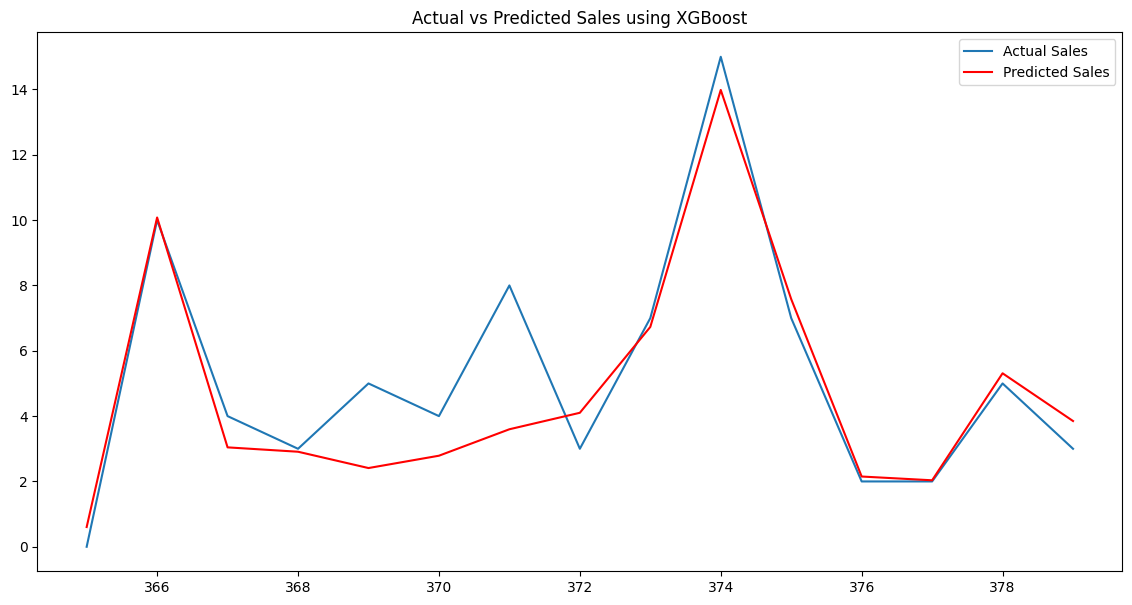

In [20]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [21]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'eta': 0.3, 'colsample_bytree': 0.7}


In [22]:
best_model = random_search.best_estimator_

In [23]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [24]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.33966661849342417
MAE: 1.2868836873952831


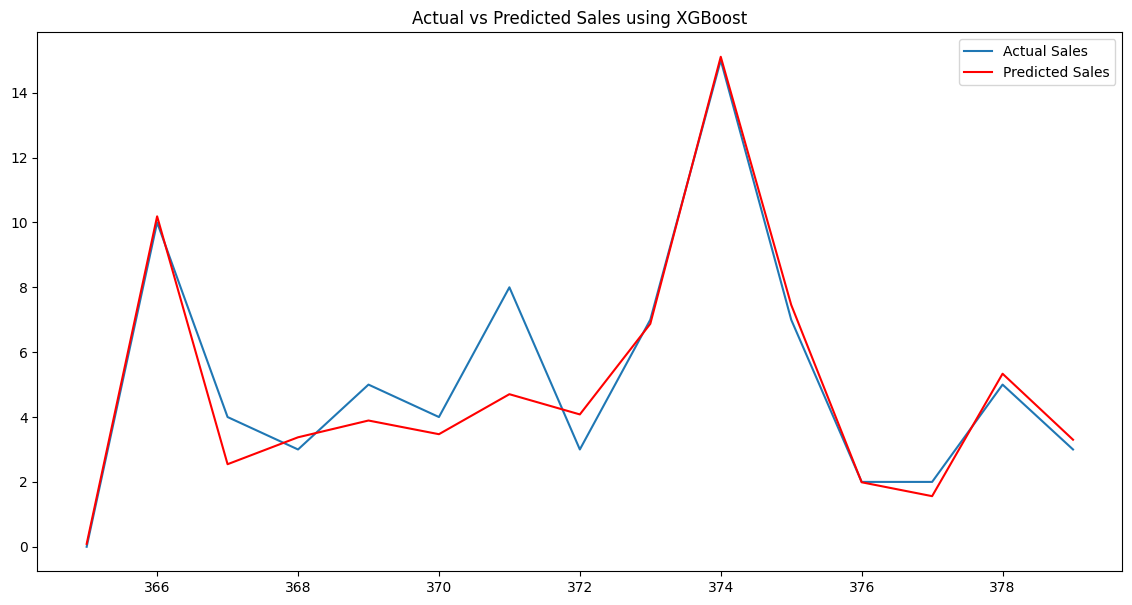

In [25]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [33]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00


In [34]:
import mlflow

In [35]:
# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/Time Series/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [36]:
# Set up experiment name
mlflow.set_experiment("Test Experiment")

2025/05/09 13:03:16 INFO mlflow.tracking.fluent: Experiment with name 'Test Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/My Drive/Time Series/mlflow_results/736670555357268872', creation_time=1746795796866, experiment_id='736670555357268872', last_update_time=1746795796866, lifecycle_stage='active', name='Test Experiment', tags={}>

In [37]:
with mlflow.start_run(run_name="test_run"):
    mlflow.log_param("param1", 5)
    mlflow.log_metric("metric1", 0.87)

In [38]:
!pip install pyngrok --quiet

In [39]:
from pyngrok import ngrok, conf
import getpass
import subprocess

In [40]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [42]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel (ULR for MLFLow UI) \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel (ULR for MLFLow UI) "https://c584-34-105-80-31.ngrok-free.app" 
